In [1]:
#Import necessary packages
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.layers import *
from keras.initializers import glorot_uniform
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#Import data
#Creating empty lists for DF creation
train = []
label = []
#Going through labels and images and adding their paths to the lists
for i in os.listdir('/content/drive/MyDrive/data/train'):
    train_class = os.listdir(os.path.join('/content/drive/MyDrive/data/train', i))
    for j in train_class:
        image = os.path.join('/content/drive/MyDrive/data/train', i, j)
        train.append(image)
        label.append(i)

In [6]:
#Creating a dataframe
df = pd.DataFrame({'Image': train, 'Labels': label})
df

,Image,Labels
0,/content/drive/MyDrive/data/train/Mild/fca931d...,Mild
1,/content/drive/MyDrive/data/train/Mild/eed4afc...,Mild
2,/content/drive/MyDrive/data/train/Mild/fe2df69...,Mild
3,/content/drive/MyDrive/data/train/Mild/ef81093...,Mild
4,/content/drive/MyDrive/data/train/Mild/f72ef9c...,Mild
...,...,...
3657,/content/drive/MyDrive/data/train/Severe/6089f...,Severe
3658,/content/drive/MyDrive/data/train/Severe/16606...,Severe
3659,/content/drive/MyDrive/data/train/Severe/6d0c0...,Severe
3660,/content/drive/MyDrive/data/train/Severe/0dc8d...,Severe


In [7]:
#Training Testing Split
from sklearn.utils import shuffle
df = shuffle(df)
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2)

To create more images to work with and for better generalisation we will augment our training data with rescaled, sheared and vertically flipped images. Testing set is only rescaled.

In [8]:
#Data Augmentation
aug_train = ImageDataGenerator(rescale=1/255,  shear_range=0.2,
                               vertical_flip=True, validation_split=0.15)
aug_test = ImageDataGenerator(rescale=1/255)
#Applying generator to DF
train_generator = aug_train.flow_from_dataframe(
    train_df,
    directory='./',
    x_col="Image",
    y_col="Labels",
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    subset='training')

validation_generator = aug_train.flow_from_dataframe(
    train_df,
    directory='./',
    x_col="Image",
    y_col="Labels",
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    subset='validation')

test_generator = aug_test.flow_from_dataframe(
    test_df,
    directory='./',
    x_col="Image",
    y_col="Labels",
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32)


Found 2490 validated image filenames belonging to 5 classes.
Found 439 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.


Residual blocks help with circumventing the vanishing gradient problem and are implemented in a seperate python function which is imported here. The input is passed through ZeroPadding2D, Conv2D, BatchNormalization, MaxPooling2D and then through 3 resblocks. The output of which is pooled and flattened, then reduced until we get 5 output classes.

In [9]:
from resblock import resblock
#Creating the Network
input_shape = (256, 256, 3)

#Input Tensor
X_input = Input(input_shape)
#Zero-padding
X = ZeroPadding2D((3,3))(X_input)

# Before Resblocks
X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

#Adding 4 Resblocks from function
X = resblock(X, filter = [64, 64, 256], stage = 2) #1
X = resblock(X, filter = [128, 128, 512], stage = 3) #2
X = resblock(X, filter = [256, 256, 1024], stage = 4) #3
#X = resblock(X, filter = [512, 512, 2048], stage = 5) #4

#Average pooling
X = AveragePooling2D((2,2), name  = 'Average_Pooling')(X)

#Flatten
X = Flatten()(X)
#Dense layer - Softmax for multiclass prediction
X = Dense(5, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)
#Final model
model = Model( inputs= X_input, outputs = X, name = 'Resnet18')
model.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 262, 262, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1 (Conv2D)              (None, 128, 128, 64)         9472      ['zero_padding2d[0][0]']      
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1[0][0]']        

In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Earlystopping is added to the model which can halt the training of the model if the validation loss stops improving, avoiding overfitting. Using ModelCheckpoint we can save the best version of the model.

In [11]:
#Introducing earlystopping to model
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose=1, patience = 15)
#Saving last best model
check = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only = True)

In [12]:
#Training the model
resu = model.fit(train_generator, steps_per_epoch=train_generator.n // 32, epochs=20, validation_data = validation_generator, validation_steps = validation_generator.n // 32, callbacks=[check , earlystopping])

Epoch 1/20
77/77 [==============================] - ETA: 0s - loss: 1.8472 - accuracy: 0.5932 
Epoch 1: val_loss improved from inf to 1.68601, saving model to weights.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


77/77 [==============================] - 2101s 27s/step - loss: 1.8472 - accuracy: 0.5932 - val_loss: 1.6860 - val_accuracy: 0.2764
Epoch 2/20
77/77 [==============================] - ETA: 0s - loss: 0.8081 - accuracy: 0.7168
Epoch 2: val_loss did not improve from 1.68601
77/77 [==============================] - 57s 745ms/step - loss: 0.8081 - accuracy: 0.7168 - val_loss: 1.7499 - val_accuracy: 0.2572
Epoch 3/20
77/77 [==============================] - ETA: 0s - loss: 0.7878 - accuracy: 0.7225
Epoch 3: val_loss did not improve from 1.68601
77/77 [==============================] - 58s 760ms/step - loss: 0.7878 - accuracy: 0.7225 - val_loss: 1.8498 - val_accuracy: 0.2644
Epoch 4/20
77/77 [==============================] - ETA: 0s - loss: 0.7542 - accuracy: 0.7229
Epoch 4: val_loss improved from 1.68601 to 1.63707, saving model to weights.hdf5
77/77 [==============================] - 58s 749ms/step - loss: 0.7542 - accuracy: 0.7229 - val_loss: 1.6371 - val_accuracy: 0.2812
Epoch 5/20
77/7

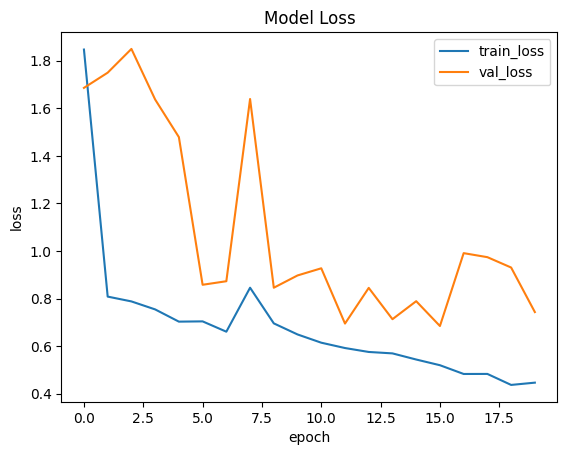

In [13]:
#Training plots
plt.plot(resu.history['loss'])
plt.plot(resu.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc = 'upper right')
plt.show()

From the training curves we can see that, the model had stopped improving much further and training was stopped at a good time. The validation training curve is highly erratic, which may indicate an unrepresentative validation dataset. A bigger validation dataset could help.

In [21]:
import PIL
#Dict to assign names to indexes
labels = {0: 'Mild', 1: 'Moderate', 2: 'No_DR', 3:'Proliferate_DR', 4: 'Severe'}
#Initializing lists for storage
prediction = []
original = []
image = []
count = 0

for item in range(len(test_df)):
  #Resize image and add to storage list
  img= PIL.Image.open(test_df['Image'].tolist()[item])
  img = img.resize((256,256))
  image.append(img)
  #Pre-process for prediction
  img = np.asarray(img, dtype= np.float32)
  img = img / 255
  img = img.reshape(-1,256,256,3)
  #Predict
  predict = model.predict(img)
  #Retrieving highest prediction and storing
  predict = np.argmax(predict)
  prediction.append(labels[predict])
  #Storing real label
  original.append(test_df['Labels'].tolist()[item])

#To gauge performance
from sklearn.metrics import accuracy_score
score = accuracy_score(original, prediction)
print("Test Accuracy : {}".format(score))

1/1 [==============================] - 0s 20ms/step
Test Accuracy : 0.7557980900409277


                precision    recall  f1-score   support

          Mild       0.44      0.72      0.54        82
      Moderate       0.71      0.62      0.66       194
         No_DR       0.94      0.98      0.96       358
Proliferate_DR       0.40      0.29      0.34        59
        Severe       0.62      0.20      0.30        40

      accuracy                           0.76       733
     macro avg       0.62      0.56      0.56       733
  weighted avg       0.76      0.76      0.75       733



Text(0.5, 1.0, 'Confusion_matrix')

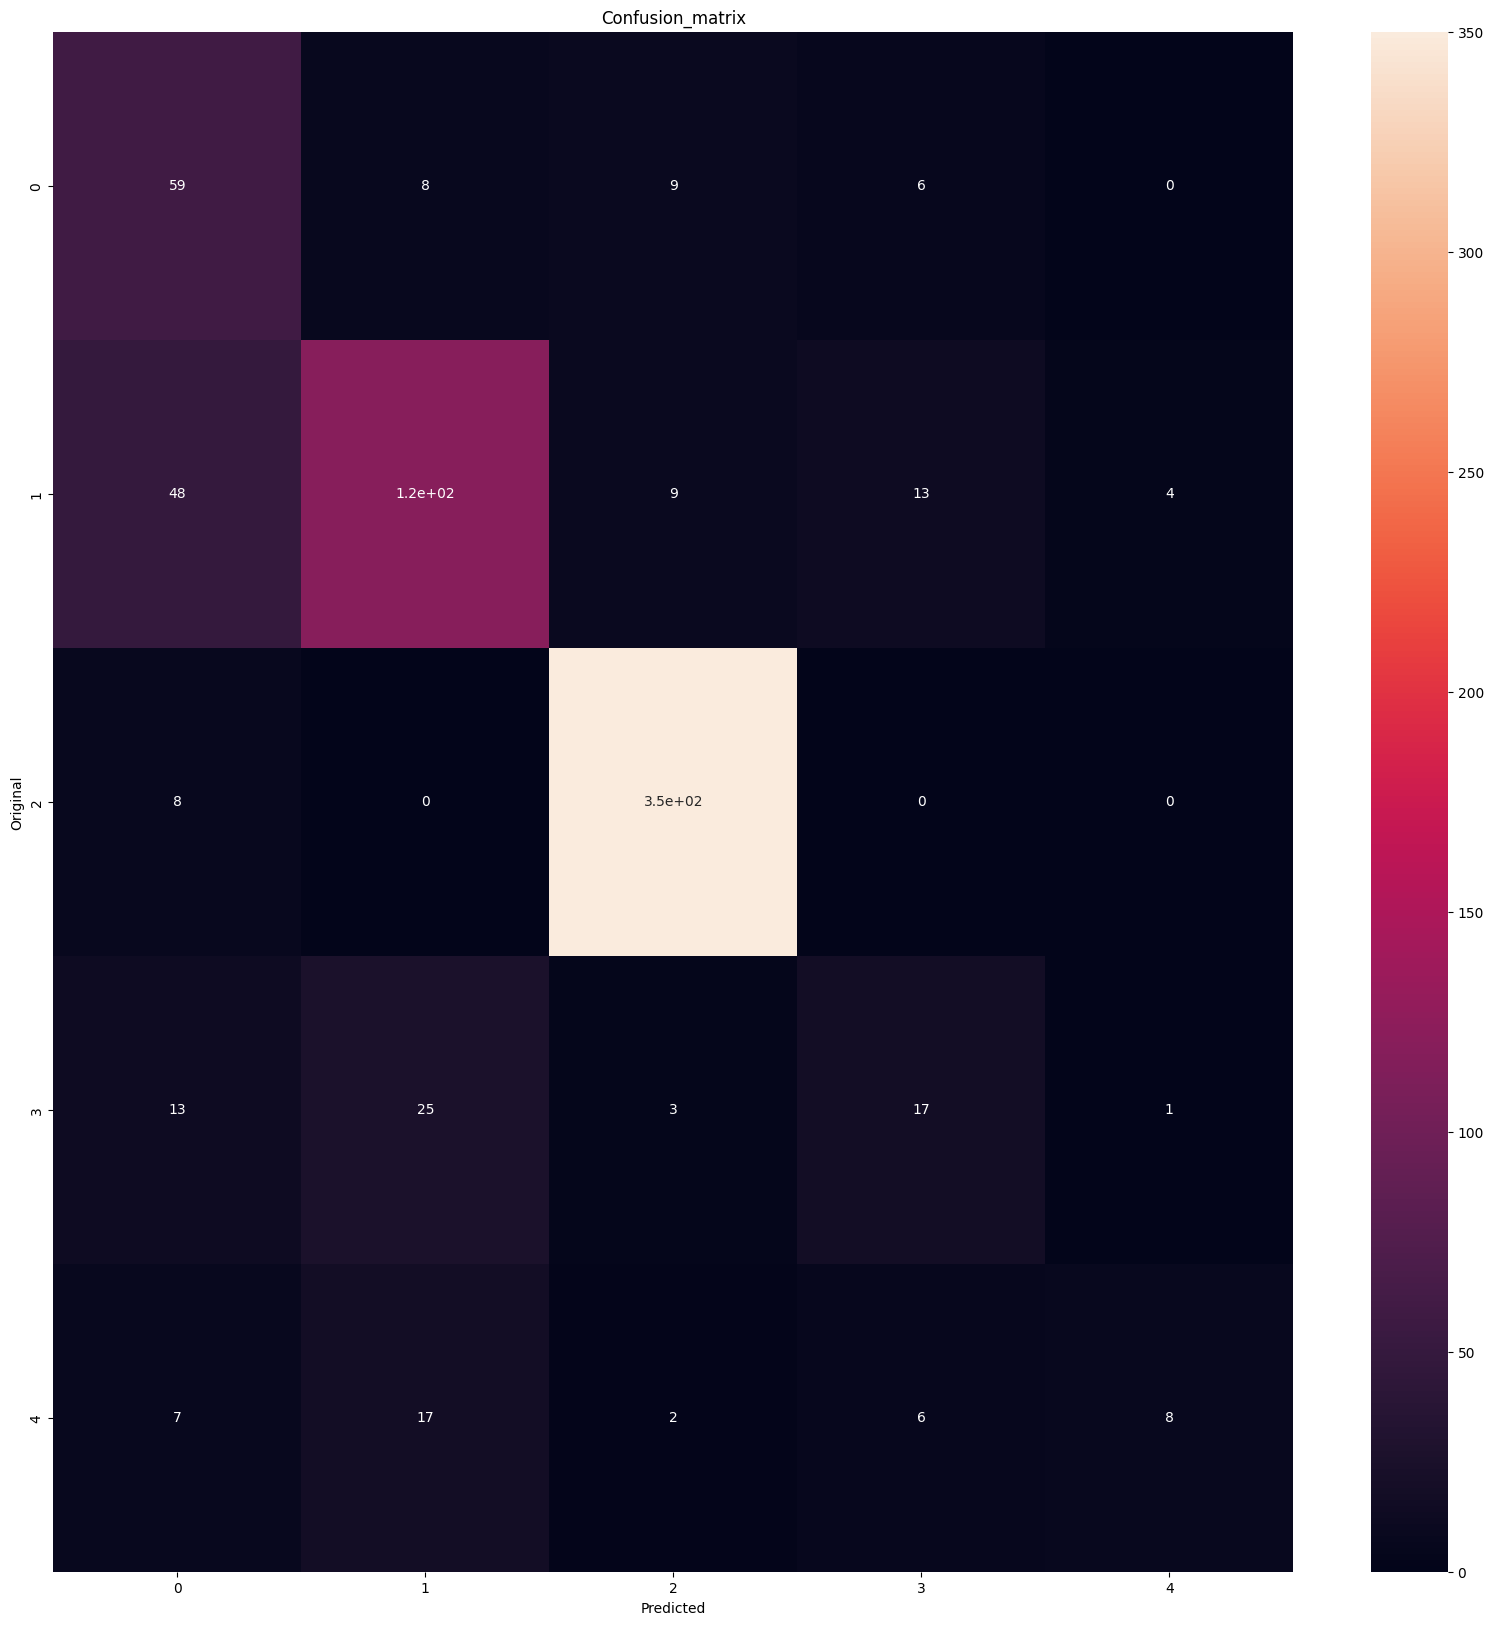

In [22]:
from sklearn.metrics import confusion_matrix, classification_report
#Printing classification report
print(classification_report(np.asarray(original), np.asarray(prediction)))
# plot the confusion matrix
plt.figure(figsize = (20,20))
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')

The model performs well in detecting DR, but not so well in revealing its severity. As a preliminary review tool it does well, and is not a final say when it comes to diagnosing someone with DR. 

The model exhibits low precision for the Mild class, meaning it often mislabels non-Mild cases as Mild, though high recall indicates successful identification of actual Mild cases. For Moderate cases, the model shows improved precision and recall, reflecting decent performance. It excels in predicting the No-DR class, with both high precision and recall, demonstrating strong reliability in identifying cases with no diabetic retinopathy. Conversely, the model struggles significantly with the Proliferate-DR class, marked by low precision and recall, leading to many incorrect and missed identifications. Similarly, the performance for Severe cases is poor, with frequent misidentifications and a notable number of missed cases.